## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [1]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task
import numpy as np
import csv
from datetime import datetime
import keras

dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y_%H%M%S")

num_episodes = 1000
runtime = 5.0                                     # time limit of the episode
init_pose = np.array([0.0, 0.0, 5.0, 0.0, 0.0, 0.0])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
target_pos = np.array([0.0, 0.0, 10.0])            # target pose
file_output = 'data_policysearch_'+timestampStr+'.csv'          # file name for saved results


task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos=target_pos)
done = False

labels = ['episode', 'time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 'reward']
rewards = []  # to store the total reward per episode
allrewards = []
agent = PolicySearch_Agent(task) 

with open(file_output, 'w', newline='\n', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode, also resets task     
        total_reward = 0
        results = {x : [] for x in labels}  # to store the trajectory of the current episode
        done = False    

        while True:
            action = agent.act(state) # delivers an action for the current state
            next_state, reward, done = task.step(action) # push the simulation further
            
            agent.step(action, reward, next_state, done)
            
            # store the details of the current episode
            to_write = [i_episode]+[task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v)+ list(action)+[reward]
            for ii in range(len(labels)):
                results[labels[ii]].append(to_write[ii])
            writer.writerow(to_write)                        
            
            state = next_state
            total_reward += reward    

            if done:
                rewards.append((i_episode, total_reward, task.sim.time)) #keep track of the total reward            
                break
    sys.stdout.flush()

Using TensorFlow backend.


## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over 
multiple runs. 

### Learning progress (rewards)
The following graph shows the total rewards per episode as a graph. The blue line is a smoothed version and shows the average of the last 10 episodes.

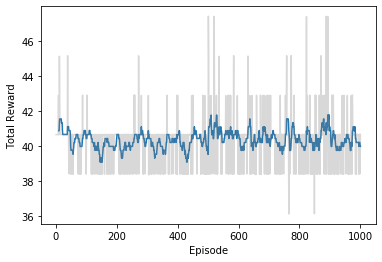

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Source: https://classroom.udacity.com/nanodegrees/nd009-ent/parts/80594ce0-6c97-4c9b-9158-08e626ee2215/modules/c0d4a29a-d82e-454c-9bb6-c517a652632d/lessons/b2eb26c6-49bb-43fa-9810-45021cc786d5/concepts/d0806599-a169-41ab-ae31-5bcbf848f091
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

eps, rews, duration = np.array(rewards).T
smoothed_rews = running_mean(rews, 10)
smoothed_dur = running_mean(duration, 10)

plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.draw()
plt.show()


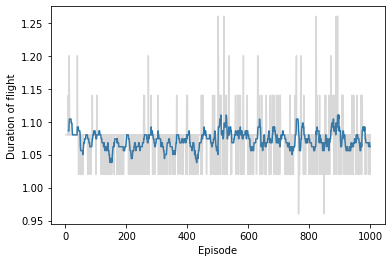

In [3]:
plt.plot(eps[-len(smoothed_dur):], smoothed_dur)
plt.plot(eps, duration, color='grey', alpha=0.3)

plt.xlabel('Episode')
plt.ylabel('Duration of flight')
plt.draw()
plt.show()

### 3D trajectory of the last run

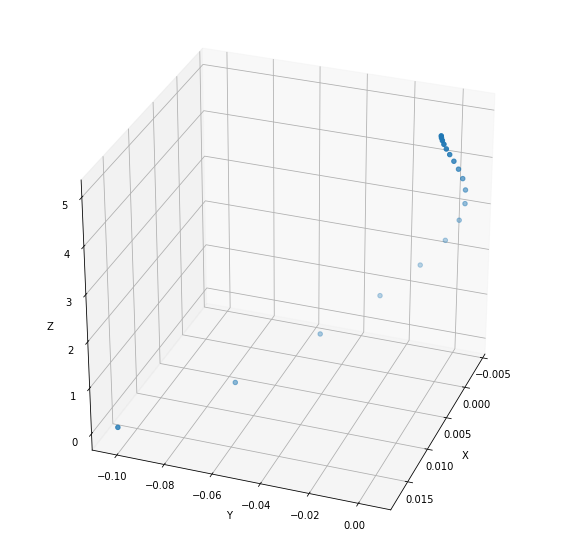

In [4]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt

def plot_trajectory(results):
    fig2 = plt.figure(figsize=(10, 10))
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.scatter(results['x'], results['y'], results['z'])

    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    ax2.view_init(30, 20)
    plt.draw()
    plt.show()
plot_trajectory(results)

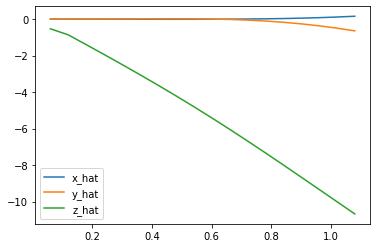

In [5]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

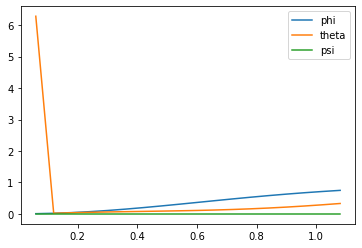

In [6]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

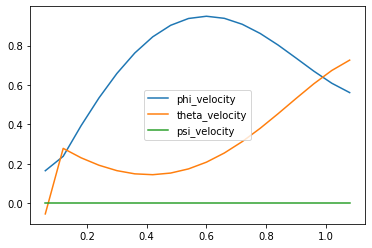

In [7]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

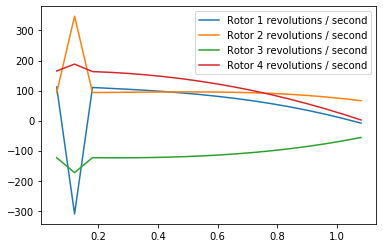

In [8]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()


In [9]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)
exit()

[ 0.01758962 -0.10265431  0.          0.74854343  0.33152558  0.        ]
[  0.1554639   -0.64516326 -10.67916414]
[0.56133332 0.72608481 0.        ]
